# Spotify-Datenverarbeitung

***Jeden Tag werden etwa 100.000 neue Songs auf Streaming-Plattformen wie Spotify hochgeladen.*** [Frankfurter Allgemeine Zeitung](https://www.faz.net/pro/digitalwirtschaft/taeglich-100-000-neue-songs-auf-spotify-co-ist-diese-masse-ein-problem-18578710.html?utm_source=chatgpt.com), 04.02.2025  

Diese enorme Menge an täglich veröffentlichten Songs führt zu einer **gigantischen Datenflut**, die kontinuierlich wächst. Musikstreaming-Dienste müssen nicht nur Millionen neuer Titel speichern, sondern auch effizient **analysieren, kategorisieren und personalisiert bereitstellen**. Dies macht die Verarbeitung von Musikdaten zu einem **klassischen Big Data Problem**, da es sich um eine **hohe Datenmenge, große Verarbeitungsgeschwindigkeit und komplexe Datenstrukturen** handelt.  

Um dieser Herausforderung zu begegnen, sind leistungsfähige **verteilte Datenverarbeitungssysteme** erforderlich, die in der Lage sind, große Mengen an Audiodaten und Metadaten effizient zu analysieren. Genau hier setzt dieses Notebook an:  

Wir haben eine **Spark-Anwendung** entwickelt, die zeigt, wie man große Mengen an Musikdaten verarbeitet, analysiert und Muster erkennt. Im weiteren Verlauf des Notebooks wird unser Ansatz Schritt für Schritt erklärt, um ein tieferes Verständnis für die **Datenverarbeitung mittels Spark** zu ermöglichen.

Am Ende des Notebooks gehen wir des Weiteren auf die **praktischen Anwendungen** ein, die sich aus der Verarbeitung großer Musikdatenmengen ergeben. Wir diskutieren, welche Erkenntnisse aus den hier generierten Ergebnissen gewonnen werden können und wie sie in **realen Szenarien** genutzt werden können.  

---

## Erklärung der Spark-Datenverarbeitung

Der gegebene Code führt mehrere Transformationen und Aktionen auf einem Spark-DataFrame durch, um statistische Analysen durchzuführen und die Ergebnisse anzuzeigen. Dabei wird die Verarbeitung in verschiedene Jobs und Stages aufgeteilt, die in der Spark UI detailliert dargestellt werden. 
Das vorliegende Notebook beschreibt diese Datenverarbeitung für ausgewählte Code-Zellen Schritt für Schritt und geht darauf ein, wie Spark den Code ausführt, welche Transformationen und Actions welche Jobs und Stages auslösen und wie Spark die Verarbeitung optimiert.

In dieser Spark-Datenverarbeitung werden über **40 Jobs** und **80 Stages** ausgeführt. Aus diesem Grund beschränkt sich die ausführliche Code-Erklärung lediglich auf ausgewählte Code-Zellen, statt auf alle einzugehen. Eine einfache Code-Erklärung findet jedoch nach jeder Zelle statt.

- **Im Detail gehen wir auf folgende Datenverarbeitungen ein:**  
  - Die Berechnung des **Dur-Prozentsatzes** ( unter **4)**) 
  - Die Berechnung der **Korrelationen** ( unter **7)**) 

### Erkenntnis zur Entstehung von Jobs in Spark

Beim Arbeiten mit Spark haben wir festgestellt, dass die Anzahl der tatsächlich ausgeführten Jobs nicht immer offensichtlich mit der Anzahl der Actions im Code übereinstimmt. Ursprünglich dachten wir, dass Spark nur dann Jobs startet, wenn eine Action wie `show()`, `count()`, `collect()` oder eine statistische Berechnung wie `stat.corr()` aufgerufen wird. In der Praxis zeigt sich jedoch, dass deutlich mehr Jobs entstehen können, selbst wenn im Code nur wenige Actions enthalten sind.

Diese Erkenntnis wurde durch die Analyse der Spark UI und des DAGs bestätigt. Spark führt manchmal **zusätzliche Jobs aus, die nicht direkt aus dem Code ersichtlich sind**. Die Ursachen dafür sind z.B.:

**Metadaten-Validierung:**  
   - Manche Transformationen, insbesondere `withColumn()`, können Jobs auslösen, wenn Spark überprüft, ob der Datentyp oder die Schemaänderung gültig ist.  
   
**Interne Optimierungen durch Spark:**  
   - Aus der Vorlesung wissen wir bereits, dass **Apache Spark einen optimierten DAG erstellt**, um Transformationen **smart auszuführen** und unnötige Schritte zu vermeiden. Spark optimiert den Abfrageplan jedoch auch während der Laufzeit, was dazu führen kann, dass zusätzliche Jobs gestartet werden, um beispielsweise Daten neu zu partitionieren oder Shuffles zu reduzieren.
   - **WholeStageCodegen:** Ein zentrales Optimierungsverfahren dabei ist **Whole-Stage Code Generation** (Dieser Schritt konnte ständig in den verschiedenen Stages beobachtet werden). Es fasst mehrere Transformationen auf Code-Ebene zusammen und generiert **optimierten Java-Code**, der mehrere Schritte in einer einzigen Pipeline verarbeitet. Dadurch werden **Funktionsaufrufe und Speicherzugriffe reduziert**, was die Verarbeitung erheblich beschleunigt – besonders bei großen Datenmengen und komplexen Abfragen.   
   - **Adaptive Query Execution (AQE):** Auch dieser Schritt konnte häufig beobachtet werden: AQE passt den physischen Ausführungsplan während der Laufzeit dynamisch an. Falls eine Partition bspw. zu groß oder zu klein ist, kann Spark die Anzahl der Partitionen dynamisch ändern. U.a. entscheidet AQE auch, ob ein Broadcast Join oder ein Sort-Merge Join besser ist, basierend auf der Größe der zu joinenden Tabellen. Dadurch können sich Stages verändern oder übersprungen werden.   

**Partitionierungs- und Shuffle-Operationen:**  
   - Operationen wie `explode()` können dazu führen, dass Spark die Daten umverteilen muss, was zu zusätzlichen Jobs führt.  

**Mehrfache Evaluierung desselben DataFrames:**  
   - Wenn ein DataFrame mehrmals in Actions verwendet wird, kann Spark die Berechnungen jedes Mal erneut ausführen, wenn keine Zwischenspeicherung (`cache()` oder `persist()`) erfolgt.  

Diese Erkenntnisse helfen uns, die Spark-Ausführung besser zu verstehen und bewusster mit Transformationen und Actions umzugehen. Besonders durch den Einsatz von **Caching** und die Kombination mehrerer Berechnungen in einer einzigen Operation können unnötige Jobs vermieden und die Effizienz verbessert werden.  
**In unserer lokalen Umgebung haben wir bewusst auf Caching verzichtet**, da dies den verfügbaren RAM schnell überlasten könnte. In einer verteilten Cluster-Umgebung wäre Caching hingegen eine sinnvolle Optimierung, um redundante Berechnungen zu vermeiden.

---

### **Kurzbeschreibung des Codes**

#### **0)** Bereinigung der CSV-Datei
- In diesem Initialen Schritt wird einer der hier benutzten Datenquellen bereinigt.
- Die bereinigten Zeilen werden in eine neue Datei gespeichert, um die Datenverarbeitung mit dieser Datei durchzuführen.

#### **1)** Initialisierung der Spark Session und Definition des Schemas
- Es wird eine Spark Session gestartet
- Ein Schema wird definiert, um die verschachtelten Datenstrukturen aus den Pickle-Dateien zu verarbeiten.

#### **2)** Einlesen und Joinen der CSV- und Pickle-Daten
- Die Datenverarbeitung im Rahmen dieser Spark-Anwendung arbeitet mit zwei verschiedenen Datenquellen, die lokal an einem Ort gespeichert sind. (Die CSV-Datei und ein Ordner mit den Pickle-Dateien)
- Die CSV-Datei wird mit Spark eingelesen
- Eine Liste aller Pickle-Dateien wird erstellt, und die Dateien werden parallel mithilfe von Spark RDDs verarbeitet.
- Relevante Felder aus den Pickle-Dateien werden extrahiert und in einen Spark DataFrame umgewandelt.
-  Die Pickle-Daten werden mit den CSV-Daten über die Spalte `track_uri` verknüpft, um die Musik-Daten aus den Pickle-Dateien um Datenfelder wie bspw. "Songtitel" anzureichern.

#### **3)** Join- und Fail-Informationen
- Es wird überprüft, wie viele Dateien erfolgreich verarbeitet und miteinander verknüpft wurden und wie viele fehlerhaft waren.
- Der kombinierte DataFrame enthält im vorliegenden Datensatz die vollständigen Informationen aus beiden Quellen.

#### **4)** Berechnung des Modes (Major = 1 und Minor = 0) und daraus der Prozentsatz von Major (Dur)
- Eine neue Spalte `is_major` wird erstellt, die prüft, ob ein Song in einer Dur-Tonart (Major) ist.
- Der durchschnittliche Prozentsatz an Songs in Dur wird berechnet und im DataFrame als `major_percentage` gespeichert.

#### **5)** Berechnung von Sections und Segments pro Sekunde und ihrer Korrelation
- Auf die verschachtelten Strukturen im DataFrame(`segments` und `sections`)wird zugegriffen. Diese werden mit der duration_ms (der Dauer eines Songs in ms) verrechnet und somit wird die Anzahl pro Sekunde ermittelt.
- Der Zusammenhang zwischen der Zeit pro Section und der Segmentdichte wird berechnet.

#### **6)** DataFrame auf Korrelation vorbereiten
- Das DataFrame wird zur Berechnung der Korrelationen zwischen den Werten `energy`, `danceability` und `loudness_max_segment` vorbereitet.
- Nicht benötigte Spalten werden entfernt, und die verbleibenden Spalten werden in geeignete numerische Datentypen (`float`, `double`) umgewandelt.
- Null-Werte werden gefiltert, um korrekte Korrelationen zu berechnen.
- Die gefilterten Daten werden in ein neues DataFrame `filtered_df` gespeichert.

#### **7)** Berechnung von Korrelationen zwischen `Energy`, `Loudness Max` und `Danceability`
- Die Korrelationen zwischen:
  - `Energy` und `Loudness Max`
  - `Loudness Max` und `Danceability`
  - `Energy` und `Danceability`
  werden berechnet und im Terminal ausgegeben.

#### **8)** Darstellung der Korrelationen
- Die bereinigten Daten werden mit `matplotlib` und `seaborn` visualisiert:
  - Hexbin-Diagramme zeigen die Punktdichte für die in 7) berechnete Korrelation

---

### **0)** Bereinigung der CSV-Daten 

In [9]:
import csv

# Original- und Zielpfade
csv_path = "../data/main_dataset.csv"  # Eingabedatei
output_file = "../data/main_final_dataset.csv"  # Endgültige Ausgabedatei

# Öffne die Eingabedatei und führe beide Bereinigungen nacheinander durch
with open(csv_path, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
    for line in infile:
        # Schritt 1: Entferne `;;;` am Ende der Zeile (falls vorhanden)
        cleaned_line = line.rstrip()  # Entferne Leerzeichen oder Steuerzeichen
        if cleaned_line.endswith(';;;'):
            cleaned_line = cleaned_line[:-3]  # Entferne die letzten drei Zeichen
        
        # Schritt 2: Entferne äußere Anführungszeichen (nur am Anfang und Ende der Zeile)
        if cleaned_line.startswith('"') and cleaned_line.endswith('"'):
            cleaned_line = cleaned_line[1:-1]  # Entferne das erste und letzte Zeichen

        # Schritt 3: Ersetze doppelte Anführungszeichen ("") durch einfache Anführungszeichen (")
        cleaned_line = cleaned_line.replace('""', '"')

        # Schreibe die bereinigte Zeile in die Zieldatei
        outfile.write(cleaned_line + "\n")

print(f"Die Datei wurde komplett verarbeitet und unter {output_file} gespeichert.")


Die Datei wurde komplett verarbeitet und unter ../data/main_final_dataset.csv gespeichert.


Dieser Code dient der **Bereinigung einer CSV-Datei** und wird **lokal mit Python** ausgeführt, ohne die Verwendung von Spark. Die folgenden Schritte werden durchgeführt:

1. **Entfernung von `;;;` am Ende der Zeile:**  
   - Überprüft, ob die Zeile mit `;;;` endet, und entfernt diese, falls vorhanden.

2. **Entfernung äußerer Anführungszeichen:**  
   - Wenn eine Zeile sowohl am Anfang als auch am Ende Anführungszeichen (`"`) enthält, werden diese entfernt.

3. **Ersetzung doppelter Anführungszeichen:**  
   - Doppelte Anführungszeichen (`""`) in der Zeile werden durch einfache Anführungszeichen (`"`) ersetzt.

Die bereinigten Zeilen werden anschließend in eine neue CSV-Datei geschrieben, welche oben in `csv_path` eingelesen werden soll.

**Hinweis: Dieser einmalige Schritt ist nötig, damit die komplette CSV korrekt in Spark eingelesen werden kann. Das ist nötig, da die Zeilen in der CSV kein konsistentes Schema haben und Spark ohne diese Vorbereinigung das inkonsistente Schema nicht einlesen kann.**  

---

### **1)** Initialisierung der Spark Session und Definition des Schemas

In [10]:
import os
import pickle
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, MapType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, when, round

# Spark-Session erstellen
spark = SparkSession.builder.appName("PickleToDataFramewithRDD").getOrCreate()

pickle_dir = "../data/1000 Spotify Dataset/Cleaned Analyses"  # Pfad zum Ordner mit Pickle-Dateien
csv_path = "../data/main_final_dataset.csv"  # Pfad zur CSV-Datei

schema = StructType([
    StructField("meta", MapType(StringType(), StringType()), True),
    StructField("track", StructType([
        StructField("num_samples", IntegerType(), True),
        StructField("duration", FloatType(), True),
        StructField("loudness", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ]), True),
    StructField("bars", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("beats", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("sections", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ])), True),
    StructField("segments", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("loudness_start", FloatType(), True),
        StructField("loudness_max", FloatType(), True),
        StructField("loudness_max_time", FloatType(), True),
        StructField("pitches", ArrayType(FloatType()), True),
        StructField("timbre", ArrayType(FloatType()), True),
    ])), True),
    StructField("tatums", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("track_uri", StringType(), True),
])

Diese Code-Zelle erstellt eine Spark-Session und definiert das Schema für die zu verarbeitenden Pickle- und CSV-Daten.  

- **Spark-Session:** Wird initialisiert, um Spark-Abfragen auszuführen.  
- **Dateipfade:** Legt die Speicherorte der Pickle- und CSV-Dateien einmalig im gesamten Code fest.  
- **zentrale Schema-Definition:** Beschreibt die Struktur der Pickle-Daten. DDas Schema umfasst bewusst alle Datenwerte einer Spotify-Pickle-Datei, um Flexibilität für zukünftige Erweiterungen der Datenverarbeitung zu gewährleisten. Dadurch können die Daten der Pickle-Datei nach Belieben verarbeitet werden, ohne das Schema anpassen zu müssen.

**Hier werden noch keine Jobs getriggert**, da lediglich die Spark-Session erstellt und Metadaten definiert werden. Erst mit einer Action würde Spark die tatsächliche Verarbeitung starten.

---


### **2)** Einlesen und Joinen der CSV- und Pickle-Daten

In [11]:
# CSV File einlesen: quote berücksichtigt das Inhalte zwischen " " als eine Spalte genommen werden
csv_df = spark.read.option("header", True).option("quote", '"').option("inferSchema", True).csv(csv_path)

# Alle Pickle-Dateien sammeln
pickle_files = [os.path.join(pickle_dir, f) for f in os.listdir(pickle_dir) if f.endswith(".pkl") or f.endswith(".pickle")]

# RDD erstellen basierend auf der Liste der Pickle-Dateien
pickle_rdd = spark.sparkContext.parallelize(pickle_files)

# Funktion zur Verarbeitung einer einzelnen Pickle-Datei
def process_pickle(filepath):
    try:
        with open(filepath, "rb") as file:
            pickle_data = pickle.load(file)
        
        # Extrahiere die benötigten Felder
        return {
            "track_uri": pickle_data.get("track_uri", "Unbekannt"),
            "bars": pickle_data.get("bars", []),
            "duration_ms": pickle_data.get("duration_ms", "Unbekannt"),
            "sections": pickle_data.get("sections", []),
            "segments": pickle_data.get("segments", []),
            "loudness_max": pickle_data.get("loudness_max", "Unbekannt"),
            "keys": pickle_data.get("keys", []),
            "track": pickle_data.get("track", [])
        }
    except Exception as e:
        return {"track_uri": None, "error": str(e)}

# Pickle-Dateien parallel verarbeiten
processed_rdd = pickle_rdd.map(process_pickle)

# RDD in Spark DataFrame umwandeln
pickle_df = spark.createDataFrame(processed_rdd, schema=schema)

# Fehlerhafte Einträge herausfiltern
valid_pickle_df = pickle_df.filter(pickle_df.track_uri.isNotNull())

# CSV-Daten mit Pickle-Daten verbinden
combined_df = valid_pickle_df.join(csv_df, valid_pickle_df["track_uri"] == csv_df["track_uri_csv"], how="inner")

Diese Code-Zelle lädt die CSV-Datei in einen Spark DataFrame und verarbeitet die Pickle-Dateien parallel mithilfe eines RDDs.

- **CSV-Datei laden:**  
  - Spark liest die CSV-Datei (`csv_path`) und speichert sie als **DataFrame in den verteilten Speicher von Spark**.  
  - Die Datei selbst wird **nicht** direkt in den RAM oder auf die Festplatte des lokalen Rechners geladen.  
  - Stattdessen speichert Spark eine **logische Referenz auf die Datei** und erstellt einen **DataFrame-Plan**, der beschreibt, wie die Daten verarbeitet werden sollen.  
  - Erst wenn eine Action ausgeführt wird, wird die Datei tatsächlich **partitioniert, verarbeitet und in den Executor-Speicher geladen**.  

- **Pickle-Dateien sammeln und als RDD verarbeiten:**  
  - Die Pfade aller Pickle-Dateien werden in einer **Python-Liste** (`pickle_files`) gespeichert.  
  - Diese Liste wird anschließend in ein **RDD umgewandelt** (`pickle_rdd`), wodurch Spark die Verarbeitung parallelisieren kann.  
  - **Anders als bei der CSV-Datei**, wo Spark eine direkte Verbindung zur Datei aufrechterhält, ist das RDD hier **sofort materialisiert**, da es aus einer Python-Liste erstellt wird.  
  - Das bedeutet, dass `pickle_rdd` **bereits alle Dateipfade im Speicher** enthält, während `csv_df` nur eine **logische Referenz auf die CSV-Datei** ist und erst bei einer Aktion tatsächlich verarbeitet wird.  

- **Verarbeitung der Pickle-Dateien:**  
  - Die Funktion `process_pickle` extrahiert die für die weiteren Berechnungen relevanten Felder aus jeder Pickle-Datei und überspringt Fehlerhafte Dateien mit Hilfe von `try und except`.  
  - Das verarbeitete RDD wird anschließend in einen Spark DataFrame (`pickle_df`) umgewandelt.  

- **Bereinigung und Verknüpfung:**  
  - **Fehlende Werte entfernen:** Zeilen mit `track_uri == None` werden gefiltert.  
  - **Daten kombinieren:** Der bereinigte Pickle-DataFrame wird mit der CSV-Datei über die `track_uri`-Spalte verknüpft.  

**Hier werden bereits zwei ersten Jobs getriggert**
1. sobald `spark.read.csv()` aufgerufen wird.

<img src="../data/images/job0.png" alt="Beispielbild" width="150">

2. sobald `pickle_rdd.map(process_pickle)` aufgerufen wird.

<img src="../data/images/job1.png" alt="Beispielbild" width="150">

    - Normalerweise ist `map` eine **lazy Transformation**.  
In diesem Fall wird `map` jedoch auf einem RDD ausgeführt, das aus einer Liste (`pickle_files`) erstellt wurde.  
Da die Funktion `process_pickle` jedoch auf tatsächliche Dateien zugreift, muss Spark die Daten sofort verarbeiten, um die Funktion zu evaluieren und sicherzustellen, dass alles funktioniert.  
Daher löst die Kombination aus `parallelize` und `map(process_pickle)` einen Job aus.  


---

### **3)** Join- und Fail-Informationen (optionale Statistik für die Anzahl korrekt verarbeiteter und gejointer Zeilen)

In [12]:
# Join-Information fürs Debugging
print(f"JOIN Information:")
print(f"- Zeilen vor Join: {valid_pickle_df.count()}")
print(f"- Zeilen nach Join: {combined_df.count()}")
print("")

# Statistik anzeigen
total_files = len(pickle_files)
successful_files = valid_pickle_df.count()
failed_files = total_files - successful_files

print(f"Statistik:")
print(f"- Gesamtanzahl der Dateien: {total_files}")
print(f"- Erfolgreich verarbeitet: {successful_files}")
print(f"- Fehlerhaft: {failed_files}")

# Test, ob CSV und Pickle korrekt gejoint wurden: 
combined_df.select("track_uri", "track_uri_csv", "name", "duration_ms").show(n=10, truncate=False)

JOIN Information:
- Zeilen vor Join: 1000
- Zeilen nach Join: 1000

Statistik:
- Gesamtanzahl der Dateien: 1000
- Erfolgreich verarbeitet: 1000
- Fehlerhaft: 0
+------------------------------------+------------------------------------+----------------------------------------------------------------+-----------+
|track_uri                           |track_uri_csv                       |name                                                            |duration_ms|
+------------------------------------+------------------------------------+----------------------------------------------------------------+-----------+
|spotify:track:4N0XG7hGoVnUKI2kuRGN1u|spotify:track:4N0XG7hGoVnUKI2kuRGN1u|Kisapmata                                                       |280947.0   |
|spotify:track:2qftkpmbxxEiVdEUfHTYPL|spotify:track:2qftkpmbxxEiVdEUfHTYPL|Vestiva i colli                                                 |218347.0   |
|spotify:track:21wH8Pxh2KQkUEeJZcpyEX|spotify:track:21wH8Pxh2KQkUEeJZcpyEX|

---

### **4)** Berechnung des Modes (Major = 1 und Minor = 0) und daraus der Prozentsatz von Major (Dur)

In [13]:
# 1. Berechnung des Durchschnittsmodus und Major-Prozentsatz für alle Songs
# Erstelle eine neue Spalte, die 1 ist, wenn der Modus 'Major' (also Dur) (1) ist, sonst 0
combined_df = combined_df.withColumn("is_major", F.when(combined_df["mode"] == 1, 1).otherwise(0))

# Gruppiere nach einer geeigneten Ebene (falls erforderlich, z.B. über alle Daten)
mode_stats = combined_df.agg(round(F.mean("is_major")*100,2).alias("major_percentage"))

# Ergebnisse anzeigen
mode_stats.show()

+----------------+
|major_percentage|
+----------------+
|            65.6|
+----------------+



#### **1. Transformation: Hinzufügen der Spalte `is_major`**

- Spark fügt eine neue Spalte `is_major` hinzu, basierend auf der Bedingung `mode == 1`. 
- Die Transformation erfolgt **lazy**, das heißt, die Spalte wird nicht sofort berechnet. Stattdessen erstellt Spark einen neuen Plan für den DataFrame, der diese Transformation enthält.
- Erst wenn eine Action wie `agg` oder `show` ausgeführt wird, evaluiert Spark diese Transformation.

**1. Job beinhaltet die 1. Stage**

<img src="../data/images/job2.png" alt="Beispielbild" width="300">

```python
withColumn("is_major", ...)
```  
- **ParallelCollectionRDD:**
    - Spark erstellt ein RDD, das die Partitionen des ursprünglichen DataFrames darstellt.
- **MapPartitionsRDD:**
    - Hier wird die Transformation angewendet. Spark geht partitionenweise vor und prüft für jede Zeile, ob `major == 1` gilt.
    - Falls ja, wird die neue Spalte `is_major` mit `True` gefüllt, sonst mit `False`. 

#### **2. Transformation: Aggregation der Daten**

Die Aggregation berechnet den Mittelwert der Spalte `is_major`, um zu bestimmen, wie oft `mode == 1` auftritt. Da diese Berechnung über alle Partitionen hinweg erfolgen muss, wird ein Shuffle notwendig.


**2. Job beinhaltet die 2. Stage**

<img src="../data/images/job3.png" alt="Beispielbild" width="300">

```python
combined_df.agg(...)
```
- **FileScanRDD:**
    - Spark liest die Daten aus dem DataFrame, einschließlich der neuen Spalte `is_major`.
- **Exchange:**
    - Da Aggregationen über alle Partitionen hinweg berechnet werden müssen, muss Spark die Daten shuffeln.
    - Hierbei werden die Daten nach der Spalte `is_major` neu verteilt
    - Dadurch kann Spark sicherstellen, dass alle `is_major`-Werte an einem Ort gesammelt werden, um die Berechnung durchzuführen.
      
#### **3. Aktion: Anzeige der Ergebnisse**

- Die Aktion `show()` fordert Spark auf, die Ergebnisse der Aggregation zu berechnen und sie im Driver auszugeben.
- Dies löst weitere Jobs und Stages aus, um die Berechnung abzuschließen und die Ergebnisse bereitzustellen.


**3. Job beinhaltet die 3. (skipped) und 4. Stage**

<img src="../data/images/job4.png" alt="Beispielbild" width="300">

*AQE-Optimierung und Broadcast*
- **3. Stage (skipped):**
    - AQE erkennt, dass keine zusätzliche Verarbeitung nötig ist, weil die Daten bereits optimal partitioniert sind. Er überspringt diese Stage.
- **4. Stage:**
  - **AQEShuffleRead:** AQE liest die geshuffelten Daten, die bereits verarbeitet wurden.
  - **BroadcastExchange:** Spark verteilt kleinere Datensätze effizient an alle Worker.


**4. Job beinhaltet die 5. (skipped) und 6. Stage**

<img src="../data/images/job5.png" alt="Beispielbild" width="300">

```python
mode_stats.show()
```
- **5. Stage (skipped):** Auch hier überspringt AQE unnötige Berechnungen, da er erkennt, dass die Daten bereits optimal organisiert sind.
- **6. Stage:**
  - **AQEShuffleRead:** Spark liest die geshuffelten Daten.
  - **Exchange:** Die Ergebnisse werden an den Driver gesendet.


**5. Job beinhaltet die 7. (skipped), 8. (skipped) und 9. Stage**

<img src="../data/images/job6.png" alt="Beispielbild" width="500">

```python
mode_stats.show()
``` 
- **7. und 8. Stage (skipped):** AQE erkennt, dass diese Stages redundant sind, und überspringt sie.
- **9. Stage:**
  - **Exchange:** Die Daten werden für die finale Ausgabe geshuffelt.
  - **mapPartitionsInternal:** Dies ist der letzte Schritt, bei dem die Daten partitionenweise verarbeitet und an den Driver zurückgegeben werden. Jede Partition gibt ihre finalen Werte an den Driver zurück, der sie dann in `show()` ausgibt.

---

### **5)** Berechnung von Sections und Segments pro Sekunde und ihrer Korrelation

In [15]:
# Berechnung der benötigten Spalten und Sortierung
results_df = combined_df.select(
    "name",
    (col("duration_ms").cast("float") / 1000).alias("duration_sec"),  # Dauer in Sekunden
    F.round(
        when(col("duration_ms") > 0, 
             1 / (size(col("sections")) / (col("duration_ms").cast("float") / 1000))
        ).otherwise(None), 2).alias("sections_per_second_reciprocal"),  # Gerundeter Kehrwert sections pro Sekunde
    F.round(
        when(col("duration_ms") > 0, 
             size(col("segments")) / (col("duration_ms").cast("float") / 1000)
        ).otherwise(0), 2).alias("segments_pro_sekunde")  # Gerundete segments pro Sekunde
).orderBy(col("sections_per_second_reciprocal").desc())  # Sortierung nach Sekunden pro Section absteigend

# Berechnung der Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde
correlation = results_df.stat.corr("sections_per_second_reciprocal", "segments_pro_sekunde")

# Prüfen, ob das Ergebnis None ist, bevor es gerundet wird
correlation_rounded = py_round(correlation, 2) if correlation is not None else None

# Ausgabe der Korrelation
print(f"Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: {correlation_rounded}")

# Ergebnisse anzeigen
results_df.show(n = 10, truncate=False)

Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: 0.06
+------------------------------------------------------------+------------+------------------------------+--------------------+
|name                                                        |duration_sec|sections_per_second_reciprocal|segments_pro_sekunde|
+------------------------------------------------------------+------------+------------------------------+--------------------+
|Dotted 8th & 16th Rhythm(Track 5 Disc 2)                    |192.333     |96.17                         |1.66                |
|Portal 3                                                    |370.961     |61.83                         |6.68                |
|Miedo                                                       |117.4       |58.7                          |2.8                 |
|Clouds & Cream                                              |174.347     |58.12                         |4.06                |
|Shurik'n                      

#### 1. Berechnung der benötigten Spalten

Der Code berechnet die Anzahl der Sections und Segments pro Sekunde. Anschließend wird die Korrelation zwischen diesen Metriken ermittelt und das Ergebnis sortiert nach den Sekunden pro Section dargestellt.

**Sections** sind größere musikalische Abschnitte wie Strophen oder Refrain, während **Segments** viel kleinere Einheiten sind, die feine akustische Merkmale wie Tonhöhe oder Timbre beschreiben.

**Wichtige Berechnungen:**
- **`duration_sec`:**  
  - Die Dauer des Songs wird von Millisekunden (`duration_ms`) in Sekunden umgerechnet.  

- **`Anzahl Sekunden pro Section (Kehrwert)`:**  
  - Berechnet die Anzahl der Sections pro Sekunde als Kehrwert.  
  - Falls `duration_ms > 0`, wird `1 / (sections / duration_sec)` berechnet.  
  - Falls `duration_ms == 0`, wird `None` zurückgegeben.  
  - Ein niedriger Wert bedeutet viele Sections pro Sekunde, ein hoher Wert bedeutet wenige Sections pro Sekunde.  

- **`segments_pro_sekunde`:**  
  - Gibt an, wie viele Segmente pro Sekunde im Song vorkommen.  
  - Falls `duration_ms > 0`, wird `segments / duration_sec` berechnet.  
  - Falls die Dauer `0` ist, wird `0` zurückgegeben.  

#### 2. Sortierung nach `Anzahl Sekunden pro Section (Kehrwert)`

- Die Ergebnisse werden nach dieser Metrik absteigend sortiert.  
- Dadurch stehen Songs mit den **wenigsten Sections pro Sekunde (höchster Kehrwert)** ganz oben.  
- Dies hilft, Lieder mit langen musikalischen Abschnitten zu identifizieren.

#### 3. Berechnung der Korrelation

Hier wird die **Korrelation** zwischen zwei Variablen berechnet:

- `Anzahl Sekunden pro Section (Kehrwert)` vs. `segments_pro_sekunde`  
  - Untersucht, ob ein Zusammenhang zwischen **Sections pro Sekunde** und **Segments pro Sekunde** besteht.  

#### 4. Ausgabe der Ergebnisse

- Die berechnete Korrelation wird ausgegeben.  
- Der sortierte DataFrame mit den berechneten Spalten wird angezeigt.  

---

### **6)** DataFrame auf Korrelation vorbereiten 

In [17]:
# Schritt 1: Sicherstellen, dass die Spalten den Typ "double" haben
combined_df = combined_df.withColumn("energy", combined_df["energy"].cast("double")).withColumn("danceability", combined_df["danceability"].cast("double"))

# Schritt 2: Explodieren der "segments"-Spalte und Extrahieren von "loudness_max"
# Hier Zugriff auf Information der Pickle Datei: Da diese eine geschachtelte Struktur enthält, muss zunächst auf Segments zugegriffen werden und anschließend auf loudness max
exploded_df = combined_df.withColumn("segment", F.explode("segments")).withColumn("loudness_max_segment", F.col("segment.loudness_max").cast("double"))

# Schritt 3: Filtern der Zeilen, um null-Werte zu vermeiden und Berechnung der Korrelationen
filtered_df = exploded_df.filter((F.col("energy").isNotNull()) & (F.col("danceability").isNotNull()) & (F.col("loudness_max_segment").isNotNull()))


Der gegebene Code bereitet einen Spark DataFrame `combined_df` auf eine Korrelationanalyse vor. Dabei werden Datentypen sichergestellt, geschachtelte Strukturen entpackt und fehlerhafte Daten entfernt.

#### Schritt 1: Sicherstellen, dass die Spalten den richtigen Datentyp haben
- Es wird sichergestellt, dass die Spalten für die spätere Berechnung numerische Werte enthalten.
- Falls die Spalten als Strings oder ein anderer Typ gespeichert wurden, werden sie in den Datentyp `double` umgewandelt.
- Diese Umwandlung ist notwendig, da Berechnungen wie Korrelationen nur mit numerischen Werten durchgeführt werden können.


#### Schritt 2: Entpacken der geschachtelten Struktur
- Die `segments`-Spalte enthält eine Liste von Segmenten, die für jede Zeile mehrere Werte speichert.
- Durch das Entpacken wird für jedes Segment eine eigene Zeile erstellt, sodass die Daten in einer tabellarischen Struktur vorliegen.
- Anschließend wird der Wert `loudness_max` aus jedem Segment extrahiert.
- Diese Transformation ist erforderlich, da eine verschachtelte Struktur nicht direkt für Berechnungen genutzt werden kann.


#### Schritt 3: Entfernen von unvollständigen Daten
- Alle Zeilen, in denen `energy`, `danceability` oder `loudness_max` nicht vorhanden sind, werden entfernt.
- Dies ist notwendig, da statistische Berechnungen wie Korrelationen nicht mit fehlenden Werten funktionieren.
- Nach dieser Bereinigung enthält der Datensatz nur noch vollständige Werte, die für die Analyse genutzt werden können.

Am Ende liegt ein bereinigter Datensatz vor, der für statistische Analysen bereit ist. Da hier keine Action enthalten ist, wurde noch nichts berechnet oder gespeichert, sondern Spark hat nur einen Plan erstellt, was passieren soll, wenn später eine Action ausgeführt wird.
**->** Die Action folgt in der folgenden Code Zelle. (`filtered_df.stat.corr(...)`)


---

### **7)** Berechnung von Korrelationen zwischen `Energy`, `Loudness Max` und `Danceability` 

In [18]:
# Berechnung der Korrelationen
corr_energy_loudness_max = filtered_df.stat.corr("energy", "loudness_max_segment")
corr_loudness_max_danceability = filtered_df.stat.corr("loudness_max_segment", "danceability")
corr_energy_danceability = filtered_df.stat.corr("energy", "danceability")
                                                              
correlation_energy_loudness_max = py_round(corr_energy_loudness_max, 2) if corr_energy_loudness_max is not None else None
correlation_loudness_max_danceability = py_round(corr_loudness_max_danceability, 2) if corr_loudness_max_danceability is not None else None
correlation_energy_danceability = py_round(corr_energy_danceability , 2) if corr_energy_danceability is not None else None

# Ausgabe der Korrelationen
print(f"Korrelation zwischen Energy und Loudness Max: {correlation_energy_loudness_max}")
print(f"Korrelation zwischen Loudness Max und Danceability: {correlation_loudness_max_danceability}")
print(f"Korrelation zwischen Energy und Danceability: {correlation_energy_danceability}")

Korrelation zwischen Energy und Loudness Max: 0.63
Korrelation zwischen Loudness Max und Danceability: 0.32
Korrelation zwischen Energy und Danceability: 0.36


Wenn `stat.corr(...)` aufgerufen wird, führt Spark eine Reihe von Transformationen durch, die über mehrere Jobs und Stages verteilt sind. Hier ist eine detaillierte Erklärung, welche Transformationen in welcher Stage durchgeführt werden.

#### Job 1: Initialisierung und Datenaufbereitung
##### Stage 1: Laden der Daten und Vorbereitung

<img src="../data/images/stage33.png" alt="Beispielbild" width="300">

- **FileScanRDD**  
  - Da `filtered_df` auf einem DataFrame basiert, der ursprünglich aus einer Datei (`csv_df`) geladen wurde, liest Spark die Datei erneut, weil die vorherigen Transformationen nicht gecached wurden.  
  - Spark scannt die Datei, um gleich die benötigten Spalten für die Berechnung der Korrelation zu extrahieren. 
  - Falls `cache()` oder `persist()` nicht verwendet wurde, erfolgt dieses Laden jedes Mal, wenn eine Action ausgeführt wird. (*Wie zu Beginn des Notebooks bereits erläutert, verzichten wir hier bewusst auf Caching.*)

- **mapPartitions**  
    - Spark nimmt jede Partition und extrahiert aus ihr die beiden Spalten, deren Korrelation berechnet werden soll.
    - Die Werte werden in das richtige Format (`double`) umgewandelt, falls notwendig.
    - Da sich die Datenstruktur in verschachtelten Spalten befindet (z. B. durch `explode()` entstanden), werden die Werte extrahiert und in einer flachen Struktur gespeichert.
    - Das Ziel dieser **mapPartitions**-Operation ist es, sicherzustellen, dass jede Partition nur die notwendigen Werte enthält, bevor sie für Berechnungen weiterverwendet werden.

- **applySchemaToPythonRDD**  
  - Spark wandelt die in `mapPartitions` extrahierten und bereinigten Werte in einen DataFrame um, falls dies noch nicht geschehen ist. Hier ist dies schon geschehen.
  - Dennoch führt Spark möglicherweise erneute Schema-Anpassungen durch, weil `stat.corr(...)` in Python läuft und eine sichere Übergabe zwischen JVM und Python-Speicher erforderlich ist.


#### Job 2: Lokale Berechnungen in den Partitionen
##### Stage 2: Berechnung von Werten für die Korrelationsberechnung

<img src="../data/images/stage34.png" alt="Beispielbild" width="300">

**Transformationen:**
- **mapPartitions (lokale Berechnung der Zwischenwerte)**  
    - Innerhalb jeder Partition werden Werte berechnet, die für die Korrelationsberechnung relevant sind.
    - Spark fasst diese Werte in einer **Tupel-Struktur** zusammen, sodass jede Partition ein einzelnes Aggregationsobjekt enthält, das später kombiniert wird.

#### Job 3: Globale Aggregation der Partitionsergebnisse
##### Stage 3: Shuffle und Reduktion der Partitionsergebnisse

<img src="../data/images/job18.png" alt="Beispielbild" width="600">

<img src="../data/images/stage37.png" alt="Beispielbild" width="300">

**Transformationen:**
- **Exchange (Shuffle-Operation)**  
    - Da jede Partition nur ihre eigenen lokalen Summen und Produkte kennt, müssen diese nun über alle Partitionen hinweg kombiniert werden.
    - Der Shuffle stellt sicher, dass alle Werte derselben Berechnung an eine Stelle gesendet werden.

- **reduceByKey oder mapPartitions für globale Aggregation**  
    - Alle Werte aus den Partitionen werden zusammengeführt, sodass am Ende **ein globaler Wert** für jede der berechneten Werte existiert.
    - Die Berechnung erfolgt mit einer **Reduce Transformation**, bei der die Werte aus allen Partitionen kombiniert werden.

#### Job 4: Finale Berechnung und Rückgabe
##### Stage 4: Berechnung der endgültigen Korrelation

<img src="../data/images/job19.png" alt="Beispielbild" width="600">

<img src="../data/images/stage41.png" alt="Beispielbild" width="300">

**Transformationen:**
- **mapPartitionsInternal (Finale Berechnung)**  
    - Die Korrelation wird anhand der aggregierten Werte berechnet:
    - Dies geschieht jetzt nur noch in einer einzigen Partition, da alle relevanten Werte bereits global aggregiert wurden.

- **Rückgabe an den Driver**
  - Das Endergebnis der Korrelation wird an den Spark Driver gesendet und in Python als `float`-Wert zurückgegeben.

- **Daten sind bereits partitioniert:**  
  - Falls Spark erkennt, dass keine erneute Partitionierung notwendig ist, kann es einige Stages überspringen.
 
---


### **8)** Darstellung der Korrelationen

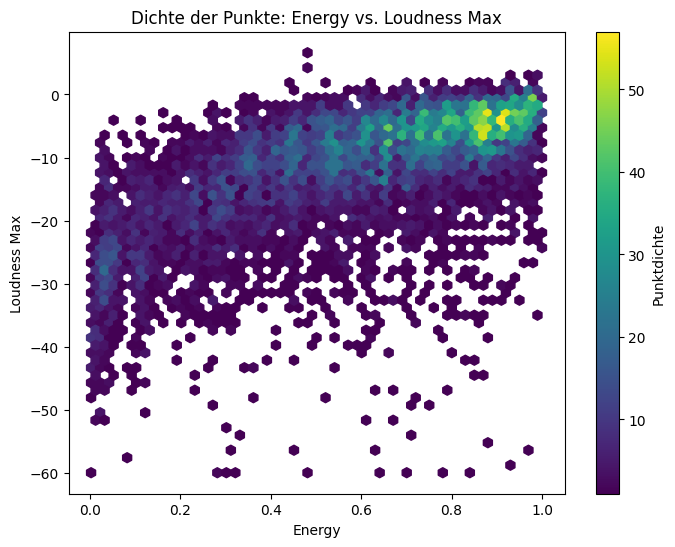

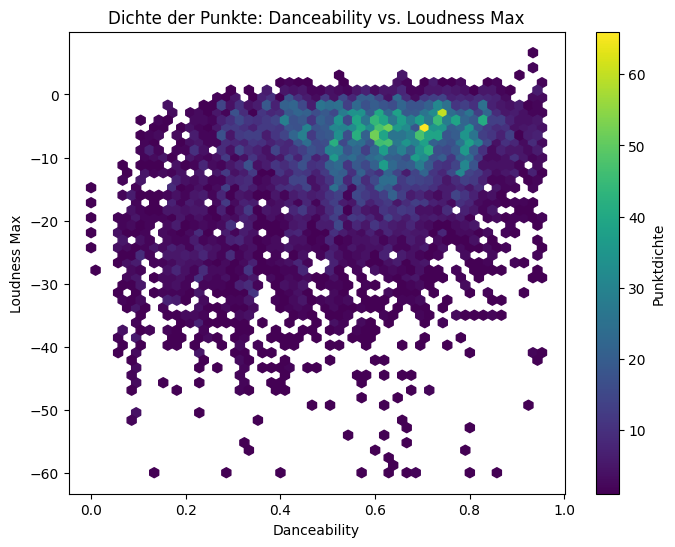

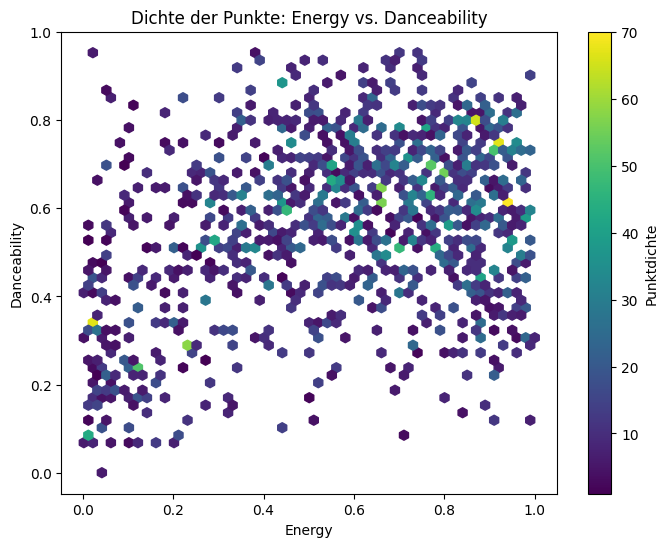

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Spark DataFrame vorbereiten
filtered_df = filtered_df.select(
    col("energy").cast("float"),
    col("loudness_max_segment").cast("float"),
    col("danceability").cast("float")
).na.drop()

# Sampling der Daten (10.000 Zeilen für Visualisierung)
sample_size = 10000
sampled_df = filtered_df.sample(fraction=sample_size / filtered_df.count())

# Umwandeln der Stichprobe in Pandas DataFrame
filtered_pd_df = sampled_df.toPandas()

# Visualisierung 1: Hexbin-Dichteplot für Energy vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Loudness Max")
plt.xlabel("Energy")
plt.ylabel("Loudness Max")
plt.show()

# Visualisierung 2: Hexbin-Dichteplot für Danceability vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["danceability"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Danceability vs. Loudness Max")
plt.xlabel("Danceability")
plt.ylabel("Loudness Max")
plt.show()

#Visualisierung 3: Energy vs. Danceability
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["danceability"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Danceability")
plt.xlabel("Energy")
plt.ylabel("Danceability")
plt.show()

#### 1. Spark DataFrame vorbereiten
- **Spaltenauswahl & Typkonvertierung:**  
  - Es werden die Spalten `energy`, `loudness_max_segment` und `danceability` aus dem Spark DataFrame extrahiert.  
  - Die Werte werden explizit in `float` umgewandelt, um sicherzustellen, dass die Daten numerisch vorliegen.  

- **Fehlende Werte entfernen:**  
  - Mit `.na.drop()` werden Zeilen mit `NULL`- oder `NaN`-Werten aus den ausgewählten Spalten entfernt.  
  - Das Ergebnis ist ein bereinigtes DataFrame, das nur vollständige Einträge enthält.

#### 2. Sampling der Daten für Visualisierung  
  - Da Spark DataFrames sehr groß sein können, ist es ineffizient, alle Daten direkt in den Speicher zu laden.  
  - Stattdessen wird eine zufällige Stichprobe von `10.000` Zeilen gezogen.

- **So funktioniert Sampling:**  
  - Die Gesamtanzahl der Zeilen im DataFrame wird berechnet (`.count()`).
  - Auf Basis des Verhältnisses von Stichprobengröße zu Gesamtgröße wird ein zufälliger Anteil der Daten mit `.sample()` ausgewählt.  


#### 3. Umwandlung in einen Pandas DataFrame
  - Der Spark DataFrame ist ein verteiltes und speicheroptimiertes Format, das nicht direkt mit Visualisierungsbibliotheken wie `matplotlib` kompatibel ist.  
  - Die Methode `.toPandas()` konvertiert den Spark DataFrame in einen Pandas DataFrame, der sich lokal verarbeiten lässt.
  - Spark sammelt die Stichprobendaten und überträgt sie in den lokalen Speicher.  
  - Dadurch liegen die Daten für Python-Bibliotheken wie z.B. `matplotlib` in einem formatgerechten DataFrame vor.

#### 4. Visualisierung mit Hexbin-Plots
- Hexbin-Diagramme visualisieren Punktdichten effizienter als Scatterplots, insbesondere bei großen Datenmengen.  
- Überlappungen werden dadurch reduziert, sodass Muster und Cluster in den Daten besser sichtbar werden.

---

## Praktische Anwendungen der Musikdatenverarbeitung  

In diesem Notebook haben wir gezeigt, wie große Mengen an Musikdaten mit **Apache Spark** verarbeitet und analysiert werden können. Dabei haben wir unter anderem die Struktur von Songs untersucht, Korrelationen zwischen verschiedenen Audio-Features berechnet und Muster identifiziert.  

Die gewonnenen Erkenntnisse haben mehrere praktische Anwendungen:  
- **Musikempfehlungen & Playlist-Generierung**: Die Analyse von **Sections, Segments und Audio-Features** wie **Energy, Loudness und Danceability** hilft, Songs präziser zu kategorisieren und automatisierte Playlists zu verbessern.  
- **Genre- und Stilklassifikation**: Durch die Untersuchung struktureller Merkmale lassen sich Songs algorithmisch bestimmten Genres zuordnen.  
- **Automatische Songzusammenfassungen**: Die Erkennung dynamischer Abschnitte ermöglicht es, Highlights oder Vorschauen aus Songs automatisiert zu extrahieren.  
- **Analyse musikalischer Trends**: Durch die Untersuchung von Veränderungen in Songstrukturen lassen sich langfristige Entwicklungen und Trends in der Musikindustrie erkennen.  
- **Zusammenhänge zwischen musikalischen Eigenschaften**: Die Berechnung von Korrelationen, z. B. zwischen **Energy und Loudness Max** oder **Danceability und Lautstärke**, gibt Einblicke in typische Muster innerhalb musikalischer Merkmale.  

Diese Ergebnisse zeigen, dass **Big Data-Technologien** essenziell sind, um riesige Musikkataloge effizient zu analysieren. Solche datengetriebenen Ansätze sind in **Musikstreaming, Produktion, Forschung und künstlicher Intelligenz** von großer Bedeutung und helfen, Musik systematisch zu verstehen und neue Anwendungen zu entwickeln.
